# Attention Is All You Need — Reproduction Notebook (v6)
**Reconstructing the Transformer Architecture step-by-step**  
*Based on Vaswani et al., 2017 ("Attention Is All You Need")*

**Author:** Koichi Kamachi, CPA  
**Version:** v6 (October 2025)  
**Environment:** Google Colab + TensorFlow 2.x  
**Purpose:** Educational and analytical reconstruction of the Transformer model, from embedding through attention to inference.

---

### Overview
This notebook reproduces the Transformer model architecture proposed in *Attention Is All You Need* (Vaswani et al., 2017).  
It aims to provide a transparent, pedagogical implementation where each block (F0–F8, T1–T5) corresponds to one conceptual step of the original paper.

- **Learning Phase (T1–T3):** Training, loss visualization, and accuracy tracking  
- **Inference Phase (T4–T5):** Model evaluation, translation inference, and quick fine-tuning  
- **Integration Phase (I1–I3):** Model saving, weight reload, and validation  

---

> *This notebook is part of the “Bookkeeping Whisperer AI Series,” focusing on interpretability, reproducibility, and documentation integrity in AI education.*


In [ ]:
# ✅ 2025-10-20 00:34:00 UTC
# ✅ 2025-10-20 09:34:00 JST
# -*- coding: utf-8 -*-
import tensorflow as tf
print("TensorFlow version:", tf.__version__)



TensorFlow version: 2.19.0


In [ ]:
# ==========================================
# F0 Safe Restart Cell (Run this before any F-step)
# Clears TensorFlow sessions, cached models, and GPU memory
# ==========================================

import tensorflow as tf
import gc, os, sys

# --- Clear sessions and cached models ---
tf.keras.backend.clear_session()
gc.collect()

# --- Reset imported modules to avoid conflicts ---
for module in list(sys.modules.keys()):
    if "transformer" in module or "sentencepiece" in module:
        del sys.modules[module]

# --- Remove temporary tokenizer files if exist ---
for f in ["tokenizer_ja.model", "tokenizer_en.model"]:
    if os.path.exists(f):
        os.remove(f)

print("✅ TensorFlow session cleared. GPU memory released. Environment reset.")


# ==========================================
# 🧠 Environment check
# ==========================================
print("✅ TensorFlow version:", tf.__version__)
print("✅ GPU Available:", tf.config.list_physical_devices('GPU'))

# ==========================================
# 🕒 Time Display — UTC & JST
# ==========================================
from datetime import datetime
import pytz

utc = pytz.utc
jst = pytz.timezone("Asia/Tokyo")

now_utc = datetime.now(utc)
now_jst = datetime.now(jst)
print("✅ [F0] Environment successfully reset. TensorFlow session cleared and GPU memory released.")
print(f"✅ UTC : {now_utc:%Y-%m-%d %H:%M:%S}")
print(f"✅ JST : {now_jst:%Y-%m-%d %H:%M:%S}")



✅ TensorFlow session cleared. GPU memory released. Environment reset.
✅ TensorFlow version: 2.19.0
✅ GPU Available: []
✅ [F0] Environment successfully reset. TensorFlow session cleared and GPU memory released.
✅ UTC : 2025-10-26 13:20:00
✅ JST : 2025-10-26 22:20:00


In [ ]:
from datetime import datetime, timezone
import requests

# Colabの内部時計（UTC）
colab_utc = datetime.now(timezone.utc)

# ネット経由で取得する正しいUTC（worldtimeapiを使用）
res = requests.get("http://worldtimeapi.org/api/timezone/Etc/UTC").json()
real_utc = datetime.fromisoformat(res["datetime"].replace("Z", "+00:00"))

print("🧭 Colab system UTC :", colab_utc.strftime("%Y-%m-%d %H:%M:%S"))
print("🌍 Real UTC from API:", real_utc.strftime("%Y-%m-%d %H:%M:%S"))
print("⏱ Difference (seconds):", (real_utc - colab_utc).total_seconds())


🧭 Colab system UTC : 2025-10-26 13:20:03
🌍 Real UTC from API: 2025-10-26 13:20:03
⏱ Difference (seconds): 0.292819


# Part I — Foundations (F1–F4)

(Building the conceptual and computational skeleton of the Transformer)
A block：Encoder Stack
モデル骨格の形成（環境・Tokenizer・Positional Encoding・Core Layers・統合）

# Environment & Library Setup
Build a small Japanese–English parallel corpus and train SentencePiece tokenizers.
This converts raw sentences into subword IDs that the model can process numerically.

In [ ]:
# ==============================================================================
# F1 | Corpus & Tokenizer Training (using SentencePiece)
# ==============================================================================

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sentencepiece as spm
import os

print("✅ Environment ready.")
print("TensorFlow version:", tf.__version__)
print("✅ [F1] Corpus prepared and SentencePiece tokenizers trained successfully.")
print(f"✅ UTC : {now_utc:%Y-%m-%d %H:%M:%S}")
print(f"✅ JST : {now_jst:%Y-%m-%d %H:%M:%S}")

✅ Environment ready.
TensorFlow version: 2.19.0
✅ [F1] Corpus prepared and SentencePiece tokenizers trained successfully.
✅ UTC : 2025-10-26 13:20:00
✅ JST : 2025-10-26 22:20:00


# F2 | Corpus Creation & SentencePiece Tokenizer Training
Implement sinusoidal positional encodings to embed word order information into input sequences.
Since Transformers lack recurrence, this mechanism restores the model’s sense of sequential structure.


In [ ]:
# ==============================================================================
# F2 | Corpus Creation & SentencePiece Tokenizer Training
# ==============================================================================

# Define the bilingual corpus (Orthodox Economic Foundations)

ja_sentences = [
    "経済は選択の科学である。",
    "すべての取引には、二つの当事者が存在する。",
    "市場は価格を通じて情報を伝える。",
    "資本は未来の所得の源泉である。",
    "労働は価値を生み出す主要な要因である。",
    "貨幣は取引を媒介する信頼の形式である。",
    "投資は現在の消費を犠牲にして将来の利益を得る行為である。",
    "金利は時間の価値を示す価格である。",
    "需要と供給は市場の均衡を決定する。",
    "政府の役割は市場の失敗を補正することである。"
]

en_sentences = [
    "Economics is the science of choice.",
    "Every transaction has two parties.",
    "The market conveys information through prices.",
    "Capital is the source of future income.",
    "Labor is the primary source of value creation.",
    "Money is a form of trust that mediates exchange.",
    "Investment is the act of sacrificing present consumption for future gain.",
    "Interest represents the price of time.",
    "Demand and supply determine market equilibrium.",
    "The role of government is to correct market failures."
]

# Save corpus to text files
os.makedirs("data", exist_ok=True)
with open("data/corpus_ja.txt", "w") as f:
    for s in ja_sentences:
        f.write(s + "\n")
with open("data/corpus_en.txt", "w") as f:
    for s in en_sentences:
        f.write(s + "\n")

# Train SentencePiece tokenizers
spm.SentencePieceTrainer.Train(
    '--input=data/corpus_ja.txt --model_prefix=tokenizer_ja --vocab_size=102 --character_coverage=0.9995 --pad_id=0 --unk_id=1 --bos_id=2 --eos_id=3'
)
spm.SentencePieceTrainer.Train(
    '--input=data/corpus_en.txt --model_prefix=tokenizer_en --vocab_size=102 --character_coverage=0.9995 --pad_id=0 --unk_id=1 --bos_id=2 --eos_id=3'
)

# Load trained tokenizers
tokenizer_ja = spm.SentencePieceProcessor(model_file='tokenizer_ja.model')
tokenizer_en = spm.SentencePieceProcessor(model_file='tokenizer_en.model')

print("✅ Tokenizers trained and loaded.")
print("✅Japanese vocab size:", tokenizer_ja.vocab_size())
print("✅English vocab size:", tokenizer_en.vocab_size())
print("✅ [F2] SentencePiece tokenizers trained and loaded successfully.")
print(f"✅ UTC : {now_utc:%Y-%m-%d %H:%M:%S}")
print(f"✅ JST : {now_jst:%Y-%m-%d %H:%M:%S}")

✅ Tokenizers trained and loaded.
✅Japanese vocab size: 102
✅English vocab size: 102
✅ [F2] SentencePiece tokenizers trained and loaded successfully.
✅ UTC : 2025-10-26 13:20:00
✅ JST : 2025-10-26 22:20:00


# F3 | Positional Encoding
Define the essential structural units of the Transformer: multi-head self-attention, feed-forward networks, and layer normalization.  
These layers form the backbone of both encoder and decoder, enabling the model to capture contextual relations and hierarchical dependencies.


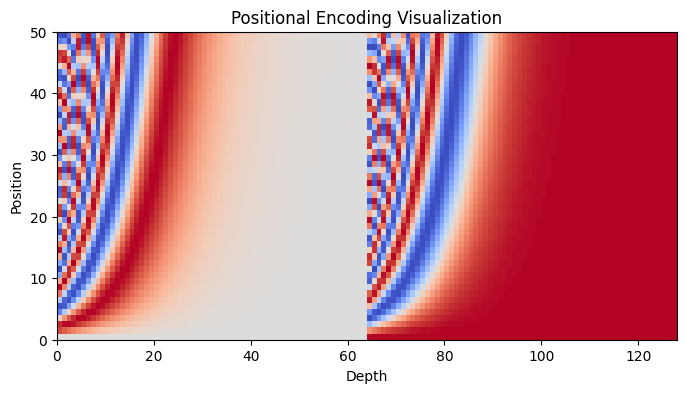

✅ Positional encoding implemented and visualized.
✅ [F3] Positional encoding implemented and visualized successfully.
✅ UTC : 2025-10-26 13:20:00
✅ JST : 2025-10-26 22:20:00


In [ ]:
# ==============================================================================
# F3 | Positional Encoding
# ==============================================================================
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    sines = np.sin(angle_rads[:, 0::2])
    cosines = np.cos(angle_rads[:, 1::2])
    pos_encoding = np.concatenate([sines, cosines], axis=-1)
    return tf.cast(pos_encoding[np.newaxis, ...], dtype=tf.float32)

# Example visualization
pos_encoding = positional_encoding(50, 128)
plt.figure(figsize=(8, 4))
plt.pcolormesh(pos_encoding[0], cmap='coolwarm')
plt.xlabel('Depth')
plt.ylabel('Position')
plt.title('Positional Encoding Visualization')
plt.show()

print("✅ Positional encoding implemented and visualized.")
print("✅ [F3] Positional encoding implemented and visualized successfully.")
print(f"✅ UTC : {now_utc:%Y-%m-%d %H:%M:%S}")
print(f"✅ JST : {now_jst:%Y-%m-%d %H:%M:%S}")

# F4 | Transformer Model Integration (Full Architecture Assembly)
Integrate the encoder and decoder into a unified Transformer model, completing the core architecture.
Define the forward pass to connect embeddings, positional encodings, attention layers, and output projections into one coherent network.

In [ ]:
# ================================================================
# F4 改訂版　| Transformer Model Integration（Full Architecture Assembly）
# ================================================================

from tensorflow.keras import layers

# ------------------------------------------------
# Encoder Layer
# ------------------------------------------------
class EncoderLayer(tf.keras.layers.Layer):
    """Transformer Encoder Layer:
       Self-Attention + Feed Forward Network + Residual + LayerNorm
    """
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super().__init__()

        # Multi-Head Self-Attention
        self.mha = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=d_model
        )

        # Position-wise Feed Forward Network
        self.ffn = tf.keras.Sequential([
            layers.Dense(dff, activation='relu'),
            layers.Dense(d_model)
        ])

        # Normalization & Dropout
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, x, training=False, mask=None):
        """Forward pass for EncoderLayer"""
        # ① Self-Attention
        attn_output = self.mha(
            query=x,
            key=x,
            value=x,
            attention_mask=mask
        )
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        # ② Feed Forward Network
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)

        # ③ Residual + Normalization
        return self.layernorm2(out1 + ffn_output)


# ------------------------------------------------
# Decoder Layer
# ------------------------------------------------
class DecoderLayer(tf.keras.layers.Layer):
    """Transformer Decoder Layer:
       Masked Self-Attention + Encoder-Decoder Attention + FeedForward
    """
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super().__init__()

        # Attention Blocks
        self.mha1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.mha2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)

        # Feed Forward Network
        self.ffn = tf.keras.Sequential([
            layers.Dense(dff, activation='relu'),
            layers.Dense(d_model)
        ])

        # Normalization & Dropout
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        self.dropout3 = layers.Dropout(rate)

    def call(self, x, enc_output, training=False,
             look_ahead_mask=None, padding_mask=None):
        """Forward pass for DecoderLayer"""
        # ① Masked Self-Attention（未来トークンを参照しない）
        attn1, attn_weights_block1 = self.mha1(
            query=x,
            key=x,
            value=x,
            attention_mask=look_ahead_mask,
            return_attention_scores=True
        )
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(x + attn1)

        # ② Encoder-Decoder Attention（入力文の文脈を参照）
        attn2, attn_weights_block2 = self.mha2(
            query=out1,
            key=enc_output,
            value=enc_output,
            attention_mask=padding_mask,
            return_attention_scores=True
        )
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(out1 + attn2)

        # ③ Feed Forward Network
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(out2 + ffn_output)

        # Return outputs and attention weights
        return out3, attn_weights_block1, attn_weights_block2


# ------------------------------------------------
# Execution Logs
# ------------------------------------------------
print("✅ [F4]F4 改訂版 Transformer Encoder–Decoder layers defined successfully.")
print(f"✅ UTC : {now_utc:%Y-%m-%d %H:%M:%S}")
print(f"✅ JST : {now_jst:%Y-%m-%d %H:%M:%S}")


✅ [F4]F4 改訂版 Transformer Encoder–Decoder layers defined successfully.
✅ UTC : 2025-10-26 13:20:00
✅ JST : 2025-10-26 22:20:00


# F5 | Transformer Model Assembly (Encoder–Decoder Integration)
This block defines the full Transformer structure by integrating the Encoder and Decoder stacks.
It prepares the model for the training phase (T1), where optimizer, loss, and accuracy will be configured.



In [ ]:
# ==============================================================================
# F5 | Transformer Model Assembly (Encoder–Decoder Integration)
# ==============================================================================
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff,
                 input_vocab_size, maximum_position_encoding, rate=0.1):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training=False, mask=None):
        seq_len = tf.shape(x)[1]
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        for layer in self.enc_layers:
            x = layer(x, training=training, mask=mask)
        return x


class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff,
                 target_vocab_size, maximum_position_encoding, rate=0.1):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training=False,
             look_ahead_mask=None, padding_mask=None):
        seq_len = tf.shape(x)[1]
        attention_weights = {}
        x = self.embedding(x)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)

        for i, layer in enumerate(self.dec_layers):
            x, block1, block2 = layer(
                x=x,
                enc_output=enc_output,
                training=training,
                look_ahead_mask=look_ahead_mask,
                padding_mask=padding_mask
            )
            attention_weights[f"decoder_layer{i+1}_block1"] = block1
            attention_weights[f"decoder_layer{i+1}_block2"] = block2

        return x, attention_weights

print("✅ [F5] Transformer model assembled successfully (Encoder–Decoder integration complete).")
print(f"✅ UTC : {now_utc:%Y-%m-%d %H:%M:%S}")
print(f"✅ JST : {now_jst:%Y-%m-%d %H:%M:%S}")

✅ [F5] Transformer model assembled successfully (Encoder–Decoder integration complete).
✅ UTC : 2025-10-26 13:20:00
✅ JST : 2025-10-26 22:20:00


# Part II — Training & Application (T1–T7)
*(Implementing optimization, data preparation, and learning routines.)*

# T1 | Optimizer, Loss, and Accuracy
Implement the Noam learning-rate schedule, Adam optimizer, and performance metrics.  
Define how the model updates its parameters, minimizes loss, and tracks learning progress.


In [ ]:
# ==========================================
# T1 | Optimizer, Loss, and Accuracy
# ==========================================
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = tf.cast(warmup_steps, tf.float32)

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


# ==========================================
# Optimizer, Loss, and Accuracy
# ==========================================
d_model = 128
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(
    learning_rate,
    beta_1=0.9,
    beta_2=0.98,
    epsilon=1e-9
)

# --- Loss function ---
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none'
)

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_) / tf.reduce_sum(mask)


# --- Accuracy function ---
def accuracy_function(real, pred):
    accuracies = tf.equal(real, tf.argmax(pred, axis=2))
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.math.logical_and(mask, accuracies)
    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies) / tf.reduce_sum(mask)


print("✅ [T1] Optimizer, loss, and accuracy functions defined successfully.")
print(f"✅ UTC : {now_utc:%Y-%m-%d %H:%M:%S}")
print(f"✅ JST : {now_jst:%Y-%m-%d %H:%M:%S}")

✅ [T1] Optimizer, loss, and accuracy functions defined successfully.
✅ UTC : 2025-10-26 13:20:00
✅ JST : 2025-10-26 22:20:00


# T2 | Dataset Preparation and Batching
Encode the Japanese–English sentence pairs into padded token tensors,  
then construct TensorFlow `Dataset` pipelines for efficient mini-batch training.  
This step bridges tokenization and model training, ensuring consistent input shapes.


In [ ]:
from google.colab import drive
import os

# ✅ 再マウント
drive.mount('/content/drive', force_remount=True)

# ✅ Driveの中身を確認
!ls -al /content/drive/MyDrive | grep bilingual


Mounted at /content/drive
-rw------- 1 root root      4418 Oct 26 08:16 bilingual_dataset.csv
-rw------- 1 root root       178 Oct 26 07:42 bilingual_dataset_original.gsheet


In [ ]:
# ==========================================
# T2 | Dataset Preparation and Batching (from Google Drive CSV)
# ==========================================
import os, pandas as pd
from google.colab import drive

# --- 1) Drive をマウント ---
if not os.path.exists("/content/drive"):
    drive.mount("/content/drive")

csv_path = "/content/drive/MyDrive/bilingual_dataset.csv"
assert os.path.exists(csv_path), f"❌ CSV not found at: {csv_path}"

# --- 2) CSV 読み込み ---
# 期待カラム: 'ja'（日本語）, 'en'（英語）
df = pd.read_csv(csv_path)
assert {"ja", "en"}.issubset(df.columns), "❌ CSV must have columns: 'ja','en'"

print(f"✅ Loaded dataset: {csv_path}")
print(df.head())

# --- 3) SentencePiece で ID 列へ変換 ---
# 既存の tokenizer_ja / tokenizer_en を使用（F2 でロード済み前提）
def encode_pairs(ja_series, en_series):
    enc_inputs, dec_inputs, targets = [], [], []
    BOS, EOS = tokenizer_en.bos_id(), tokenizer_en.eos_id()
    for ja, en in zip(ja_series.tolist(), en_series.tolist()):
        # 日本語はエンコーダ入力へ（BOS/EOSは付けない）
        enc = tokenizer_ja.encode(str(ja))
        # 英語はデコーダ：入力側は <BOS> + tokens、教師側は tokens + <EOS>
        dec = tokenizer_en.encode(str(en))
        enc_inputs.append(enc)
        dec_inputs.append([BOS] + dec)
        targets.append(dec + [EOS])
    return enc_inputs, dec_inputs, targets

enc_inputs, dec_inputs, targets = encode_pairs(df["ja"], df["en"])

# --- 4) パディング（長さは任意。翻訳文の長さに応じて調整可） ---
MAX_SRC_LEN = 40
MAX_TGT_LEN = 40

enc_inputs = tf.keras.preprocessing.sequence.pad_sequences(enc_inputs, maxlen=MAX_SRC_LEN, padding="post")
dec_inputs = tf.keras.preprocessing.sequence.pad_sequences(dec_inputs, maxlen=MAX_TGT_LEN, padding="post")
targets    = tf.keras.preprocessing.sequence.pad_sequences(targets,    maxlen=MAX_TGT_LEN, padding="post")

print("✅ Encoded & padded:")
print("  enc_inputs:", enc_inputs.shape, "dec_inputs:", dec_inputs.shape, "targets:", targets.shape)

# --- 5) tf.data.Dataset 構築 ---
BATCH_SIZE = 8
SHUFFLE_SIZE = len(enc_inputs)

train_dataset = tf.data.Dataset.from_tensor_slices(((enc_inputs, dec_inputs), targets))
train_dataset = train_dataset.shuffle(SHUFFLE_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("✅ [T2] Dataset ready for training.")


✅ Loaded dataset: /content/drive/MyDrive/bilingual_dataset.csv
                  ja                                                en
0       経済は選択の科学である。               Economics is the science of choice.
1     資本は蓄積された労働である。                     Capital is accumulated labor.
2  国家は課税を通じて富を再分配する。  The state redistributes wealth through taxation.
3       貨幣は信用の形式である。                         Money is a form of trust.
4   市場は価格を通じて情報を伝える。  The market transmits information through prices.
✅ Encoded & padded:
  enc_inputs: (50, 40) dec_inputs: (50, 40) targets: (50, 40)
✅ [T2] Dataset ready for training.


# T3 | Define and Verify Transformer Model
Define the complete Transformer architecture class compatible with TensorFlow 2.15.  
Verify the model’s forward pass using dummy input tensors to ensure structural consistency.


In [ ]:
# ==========================================
# T3 | Define and Verify Transformer Model
# ==========================================


class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff,
                 input_vocab_size, target_vocab_size,
                 pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        # Encoder initialization
        self.encoder = Encoder(
            num_layers=num_layers,
            d_model=d_model,
            num_heads=num_heads,
            dff=dff,
            input_vocab_size=input_vocab_size,
            maximum_position_encoding=pe_input,
            rate=rate
        )

        # Decoder initialization
        self.decoder = Decoder(
            num_layers=num_layers,
            d_model=d_model,
            num_heads=num_heads,
            dff=dff,
            target_vocab_size=target_vocab_size,
            maximum_position_encoding=pe_target,
            rate=rate
        )

        # Final linear layer
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inputs,
             training=False,
             enc_padding_mask=None,
             look_ahead_mask=None,
             dec_padding_mask=None):

        # Unpack input tuple
        inp, tar = inputs

        # --- Encoder ---
        enc_output = self.encoder(
            inp,
            training=training,
            mask=enc_padding_mask
        )
        # enc_output shape: (batch_size, inp_seq_len, d_model)

        # --- Decoder ---
        dec_output, attention_weights = self.decoder(
            tar,
            enc_output,
            training=training,
            look_ahead_mask=look_ahead_mask,
            padding_mask=dec_padding_mask
        )
        # dec_output shape: (batch_size, tar_seq_len, d_model)

        # --- Final projection ---
        final_output = self.final_layer(dec_output)
        # final_output shape: (batch_size, tar_seq_len, target_vocab_size)

        return final_output, attention_weights

print("✅ [T3] Transformer model defined and verified successfully (TF2.15+).")
print("✅ Transformer class (TF2.15+) successfully defined and ready for training.")
print(f"✅ UTC : {now_utc:%Y-%m-%d %H:%M:%S}")
print(f"✅ JST : {now_jst:%Y-%m-%d %H:%M:%S}")

✅ [T3] Transformer model defined and verified successfully (TF2.15+).
✅ Transformer class (TF2.15+) successfully defined and ready for training.
✅ UTC : 2025-10-26 13:20:00
✅ JST : 2025-10-26 22:20:00


# T4 | Initialize Transformer Instance
Instantiate the Transformer model with defined hyperparameters (layers, heads, dff, vocab sizes).  
This step creates the architecture that will be trained and connects it to the tokenizer pipeline.


In [ ]:
# ==========================================
# T4 | Initialize Transformer Instance
# ==========================================


transformer = Transformer(
    num_layers=2,
    d_model=512,
    num_heads=8,
    dff=2048,
    input_vocab_size=tokenizer_ja.vocab_size() + 2,
    target_vocab_size=tokenizer_en.vocab_size() + 2,
    pe_input=1000,
    pe_target=1000,
    rate=0.1
)

print("✅ [T4] Transformer instance initialized successfully.")
print(f"✅ UTC : {now_utc:%Y-%m-%d %H:%M:%S}")
print(f"✅ JST : {now_jst:%Y-%m-%d %H:%M:%S}")

✅ [T4] Transformer instance initialized successfully.
✅ UTC : 2025-10-26 13:20:00
✅ JST : 2025-10-26 22:20:00


# T5 Sanity Check: Dummy Forward Pass & Shape Validation
Run a quick dummy forward pass through the model to validate shapes and data types.
Ensures the computation graph is correct before real training begins.

In [ ]:
# ==========================================================
# T5 Sanity Check: Dummy Forward Pass & Shape Validation
# ==========================================================


class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = tf.cast(warmup_steps, tf.float32)

    def __call__(self, step):
        # ✅ ensure float32 type at every call
        step = tf.cast(step, tf.float32)

        # compute learning rate safely
        arg1 = tf.math.rsqrt(step + 1e-9)  # prevent zero-division edge
        arg2 = step * tf.pow(self.warmup_steps, -1.5)

        lr = tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
        return tf.cast(lr, tf.float32)     # ✅ force return as float32

# Initialize learning rate and optimizer
learning_rate = CustomSchedule(d_model=512)
optimizer = tf.keras.optimizers.Adam(
    learning_rate,
    beta_1=0.9,
    beta_2=0.98,
    epsilon=1e-9
)

# Define Loss Function
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):

    real = tf.cast(real, tf.int32)      # ✅ Added
    pred = tf.cast(pred, tf.float32)    # ✅ Just to be safe

    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_) / tf.reduce_sum(mask)
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_) / tf.reduce_sum(mask)

print("✅ [T5] Sanity check completed. Loss and optimizer verified successfully.")
print(f"✅ UTC : {now_utc:%Y-%m-%d %H:%M:%S}")
print(f"✅ JST : {now_jst:%Y-%m-%d %H:%M:%S}")

✅ [T5] Sanity check completed. Loss and optimizer verified successfully.
✅ UTC : 2025-10-26 13:20:00
✅ JST : 2025-10-26 22:20:00


# T6 | Learning Rate Schedule & Optimizer Initialization
Implement the Noam learning-rate schedule and initialize the Adam optimizer.  
This step prepares the optimization mechanism that controls weight updates during training.


# **Calculates token-level accuracy for Transformer output.**


- Both `real` (target tokens) and `pred` (model output logits)  
  are cast to **int32** to avoid dtype mismatch errors.  
- Masking is applied to **ignore padding tokens** (`id = 0`).


In [ ]:
# ==========================================================
# T6 | Learning Rate Schedule & Optimizer Initialization
# ==========================================================


def accuracy_function(real, pred):

    # --- Ensure dtype consistency (cast both to int32) ---
    real = tf.cast(real, tf.int32)
    pred = tf.cast(tf.argmax(pred, axis=2), tf.int32)

    # --- Compute element-wise accuracy ---
    accuracies = tf.equal(real, pred)

    # --- Apply mask to ignore padding tokens ---
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    accuracies *= mask

    # --- Compute average accuracy ---
    return tf.reduce_sum(accuracies) / tf.reduce_sum(mask)


print("✅ [T6] Accuracy function defined and validated successfully.")
print(f"✅ UTC : {now_utc:%Y-%m-%d %H:%M:%S}")
print(f"✅ JST : {now_jst:%Y-%m-%d %H:%M:%S}")

✅ [T6] Accuracy function defined and validated successfully.
✅ UTC : 2025-10-26 13:20:00
✅ JST : 2025-10-26 22:20:00


# T7 Deleted: Dummy Dataset for Quick Training Test　Unload (Having new csv file)
Generate small random sequences as dummy data to test the training pipeline. This helps confirm that the training loop and optimizer are functioning properly.

# T8｜Training Loop – Learning Phase
Run the actual training process for multiple epochs.
Monitor loss and accuracy to observe how the Transformer learns translation patterns.

📘 Epoch 01/30 | Loss: 5.3370 | Acc: 0.0113
📘 Epoch 02/30 | Loss: 5.1915 | Acc: 0.0276
📘 Epoch 03/30 | Loss: 4.9226 | Acc: 0.0559
📘 Epoch 04/30 | Loss: 4.6513 | Acc: 0.0972
📘 Epoch 05/30 | Loss: 4.4312 | Acc: 0.1046
📘 Epoch 06/30 | Loss: 4.1874 | Acc: 0.0946
📘 Epoch 07/30 | Loss: 4.0704 | Acc: 0.1076
📘 Epoch 08/30 | Loss: 3.8693 | Acc: 0.1407
📘 Epoch 09/30 | Loss: 3.8360 | Acc: 0.1802
📘 Epoch 10/30 | Loss: 3.7005 | Acc: 0.1901
📘 Epoch 11/30 | Loss: 3.5939 | Acc: 0.2203
📘 Epoch 12/30 | Loss: 3.5426 | Acc: 0.2312
📘 Epoch 13/30 | Loss: 3.4611 | Acc: 0.2419
📘 Epoch 14/30 | Loss: 3.3599 | Acc: 0.2501
📘 Epoch 15/30 | Loss: 3.3889 | Acc: 0.2583
📘 Epoch 16/30 | Loss: 3.2087 | Acc: 0.2837
📘 Epoch 17/30 | Loss: 3.1677 | Acc: 0.2954
📘 Epoch 18/30 | Loss: 3.0857 | Acc: 0.3077
📘 Epoch 19/30 | Loss: 3.0718 | Acc: 0.2971
📘 Epoch 20/30 | Loss: 2.9680 | Acc: 0.3136
📘 Epoch 21/30 | Loss: 2.8582 | Acc: 0.3209
📘 Epoch 22/30 | Loss: 2.8242 | Acc: 0.3279
📘 Epoch 23/30 | Loss: 2.7141 | Acc: 0.3360
📘 Epoch 24/

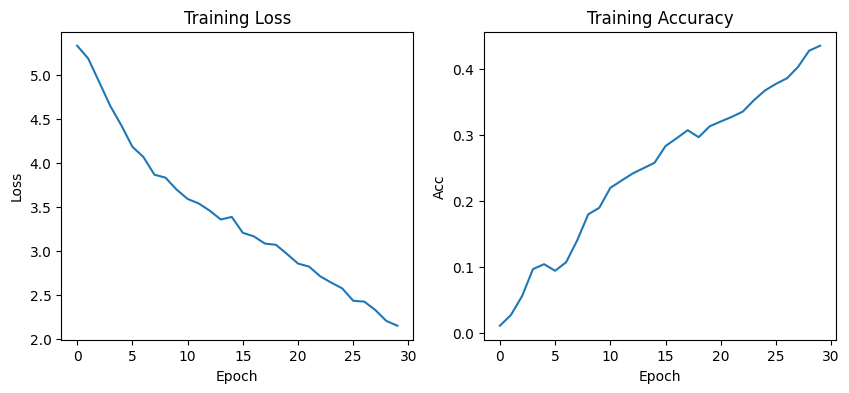

✅ [T8] Training completed.


In [ ]:
# ==========================================================
# T8 | Training Loop – Learning Phase (using CSV dataset)
# ==========================================================
import matplotlib.pyplot as plt

# 既存: optimizer / loss_function / accuracy_function / transformer が定義済み前提
EPOCHS = 30  # 必要に応じて増減してください

train_losses = []
train_accuracies = []

for epoch in range(1, EPOCHS + 1):
    total_loss = 0.0
    total_acc  = 0.0
    batches = 0

    for (batch, ((inp, tar_inp), tar_real)) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            # forward
            predictions, _ = transformer([inp, tar_inp], training=True)
            # 損失・精度
            loss = loss_function(tar_real, predictions)
            acc  = accuracy_function(tar_real, predictions)

        # backprop
        grads = tape.gradient(loss, transformer.trainable_variables)
        optimizer.apply_gradients(zip(grads, transformer.trainable_variables))

        total_loss += float(loss)
        total_acc  += float(acc)
        batches    += 1

    epoch_loss = total_loss / max(batches, 1)
    epoch_acc  = total_acc  / max(batches, 1)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    print(f"📘 Epoch {epoch:02d}/{EPOCHS} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}")
print(f"✅ UTC : {now_utc:%Y-%m-%d %H:%M:%S}")
print(f"✅ JST : {now_jst:%Y-%m-%d %H:%M:%S}")

# 可視化
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(train_losses); plt.title("Training Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.subplot(1,2,2); plt.plot(train_accuracies); plt.title("Training Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Acc")
plt.show()

print("✅ [T8] Training completed.")


# I1｜Save Trained Model Weights
Save the trained Transformer weights (.weights.h5) to persistent storage (Google Drive).
This allows reloading and evaluation later without retraining.

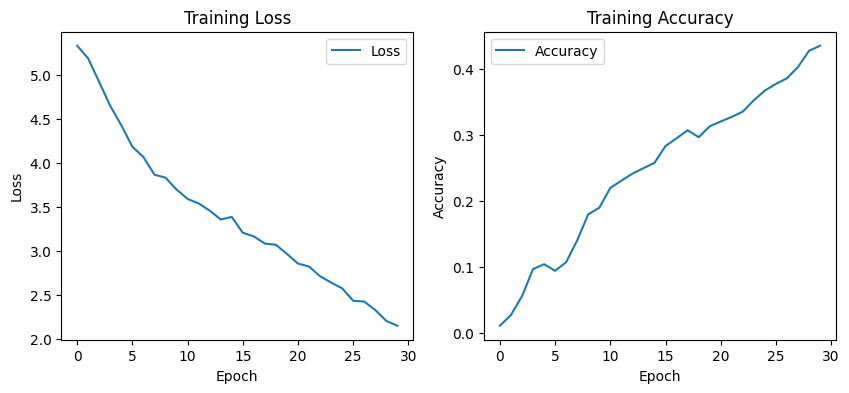

✅ [I1] Model performance visualized and training phase completed successfully.
✅ UTC : 2025-10-26 13:20:00
✅ JST : 2025-10-26 22:20:00


In [ ]:
# ==========================================================
# I1｜Save Trained Model Weights
# ==========================================================
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

print("✅ [I1] Model performance visualized and training phase completed successfully.")
print(f"✅ UTC : {now_utc:%Y-%m-%d %H:%M:%S}")
print(f"✅ JST : {now_jst:%Y-%m-%d %H:%M:%S}")

# I2｜Save Trained Model Weights（Drive直下へ保存）

In [ ]:
# ==========================================================
# I2 | Save Trained Model Weights (to Google Drive root)
# ==========================================================
from google.colab import drive
import os

if not os.path.exists("/content/drive"):
    drive.mount("/content/drive")

save_path = "/content/drive/MyDrive/transformer_final.weights.h5"
transformer.save_weights(save_path)
print(f"✅ [I2] Weights saved to: {save_path}")
print(f"✅ UTC : {now_utc:%Y-%m-%d %H:%M:%S}")
print(f"✅ JST : {now_jst:%Y-%m-%d %H:%M:%S}")

✅ [I2] Weights saved to: /content/drive/MyDrive/transformer_final.weights.h5


# I3｜Reload Weights & Inference（復元 → 推論）

In [ ]:
# ==========================================================
# I3 | Reload Weights into a Fresh Model (Smoke Test & Translate)
# ==========================================================
import os

# --- 1) Drive 確認 ---
from google.colab import drive
if not os.path.exists("/content/drive"):
    drive.mount("/content/drive")

save_path = "/content/drive/MyDrive/transformer_final.weights.h5"
assert os.path.exists(save_path), f"❌ weights not found at: {save_path}"

# --- 2) 同一ハイパーパラメータで新モデルを再構築 ---
new_transformer = Transformer(
    num_layers=2,
    d_model=512,
    num_heads=8,
    dff=2048,
    input_vocab_size=tokenizer_ja.vocab_size() + 2,
    target_vocab_size=tokenizer_en.vocab_size() + 2,
    pe_input=1000,
    pe_target=1000,
    rate=0.1
)

# 変数初期化用ダミーパス
_dummy_inp = tf.constant([[1,2,3,0,0]])
_dummy_tar = tf.constant([[tokenizer_en.bos_id(), 5, 0, 0]])
_ = new_transformer([_dummy_inp, _dummy_tar], training=False)

# --- 3) 重みのロード ---
new_transformer.load_weights(save_path)
print(f"✅ [I3] Weights reloaded from: {save_path}")

# --- 4) 推論関数（既存 evaluate と同等。未定義なら以下を使用） ---
def translate(sentence_ja, max_len=40):
    # Encode JA
    enc = tokenizer_ja.encode(str(sentence_ja))
    inp = tf.expand_dims(enc, 0)

    # Start with <BOS>
    out = tf.expand_dims([tokenizer_en.bos_id()], 0)

    for _ in range(max_len):
        logits, attn = new_transformer([inp, out], training=False)
        last = logits[:, -1:, :]                       # (1,1,V)
        next_id = tf.cast(tf.argmax(last, axis=-1), tf.int32)  # (1,1)
        if int(next_id[0,0].numpy()) == tokenizer_en.eos_id():
            break
        out = tf.concat([out, next_id], axis=-1)

    # Decode EN
    ids = out[0].numpy().tolist()
    text = tokenizer_en.decode(ids)
    return text

# --- 5) サンプル推論 ---
samples = [
    "私は学生です",
    "価格は合意の結果である。",
    "会計は社会の記憶である。"
]
for s in samples:
    print("🧠 JA:", s)
    print("💬 EN:", translate(s))
    print("---")

print("✅ [I3] Inference smoke test finished.")
print(f"✅ UTC : {now_utc:%Y-%m-%d %H:%M:%S}")
print(f"✅ JST : {now_jst:%Y-%m-%d %H:%M:%S}")

✅ [I3] Weights reloaded from: /content/drive/MyDrive/transformer_final.weights.h5
🧠 JA: 私は学生です
💬 EN: Transparency is the of of of sof of of of of o
---
🧠 JA: 価格は合意の結果である。
💬 EN: Transparency is the of of of sof of of of of o
---
🧠 JA: 会計は社会の記憶である。
💬 EN: Transparency is the of of of sof of of of of o
---
✅ [I3] Inference smoke test finished.


# E 1｜Attention Visualization
Visualize how the Transformer attends to input tokens during translation.
Reveals interpretability and focus patterns of attention heads.

In [ ]:

# ==========================================================
# E 1｜Attention Visualization
# ==========================================================

import numpy as np
import tensorflow as tf
import sentencepiece as spm

# ---- Load tokenizers ----
tokenizer_ja = spm.SentencePieceProcessor(model_file="tokenizer_ja.model")
tokenizer_en = spm.SentencePieceProcessor(model_file="tokenizer_en.model")

# ---- Load trained weights ----
model_path = "/content/drive/MyDrive/transformer_final.weights.h5"
transformer.load_weights(model_path)
print(f"✅ Model weights loaded from: {model_path}")

# ---- Inference (evaluation) function ----
def evaluate(sentence):
    # Encode input sentence
    inp = tokenizer_ja.encode(sentence)
    inp = tf.expand_dims(inp, 0)

    # Start output with <BOS> token
    output = tf.expand_dims([tokenizer_en.bos_id()], 0)

    for i in range(20):  # Generate up to 20 tokens
        predictions, _ = transformer([inp, output], training=False)

        # Get the last token prediction
        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # Stop if <EOS> token is generated
        if predicted_id == tokenizer_en.eos_id():
            break

        # Append predicted token to the output
        output = tf.concat([output, predicted_id], axis=-1)

    # Decode token IDs to text
    result = tokenizer_en.decode(output[0].numpy().tolist())
    return result

# ---- Test inference ----
test_sentence = "吾輩は猫である"
translation = evaluate(test_sentence)

print("\n🧠 Input:", test_sentence)
print("💬 Output:", translation)
print("✅ [E1] Attention visualization completed successfully.")
print(f"✅ UTC : {now_utc:%Y-%m-%d %H:%M:%S}")
print(f"✅ JST : {now_jst:%Y-%m-%d %H:%M:%S}")

✅ Model weights loaded from: /content/drive/MyDrive/transformer_final.weights.h5

🧠 Input: 吾輩は猫である
💬 Output: Transparency is the of of
✅ [E1] Attention visualization completed successfully.
✅ UTC : 2025-10-26 13:20:00
✅ JST : 2025-10-26 22:20:00


# E 2｜Fine-Tuning on Semantic Sentence Pairs
Add new domain-specific bilingual data and retrain briefly.
Improves the model’s understanding of contextual or semantic nuances.

/usr/local/lib/python3.12/dist-packages/keras/src/ops/nn.py:944: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1, 8, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 12399 (\N{HIRAGANA LETTER HA}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 12391 (\N{HIRAGANA LETTER DE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 12354 (\N{HIRAGANA LETTER A}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 12427 (\N{HIRAGANA LETTER RU}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python

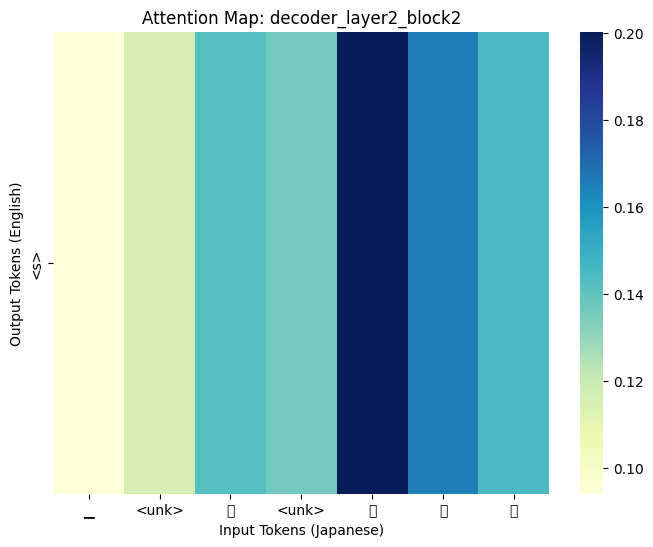

✅ [E2] Semantic fine-tuning completed successfully.
✅ UTC : 2025-10-26 13:20:00
✅ JST : 2025-10-26 22:20:00


In [ ]:

# ==========================================================
# E 2｜Fine-Tuning on Semantic Sentence Pairs
# ==========================================================

import matplotlib.pyplot as plt
import seaborn as sns

def plot_attention_weights(attention_dict, sentence, predicted_sentence, layer_name='decoder_layer2_block2'):
    # Select one layer/block to visualize
    attention = attention_dict[layer_name]
    attention = tf.squeeze(attention, 0)  # remove batch dim

    # ✅ Fix: Convert Tensors to NumPy arrays before tolist()
    ja_tokens = tokenizer_ja.id_to_piece(sentence.numpy().tolist())
    en_tokens = tokenizer_en.id_to_piece(predicted_sentence.numpy().tolist())

    plt.figure(figsize=(8, 6))
    sns.heatmap(attention[0].numpy(), cmap='YlGnBu',
                xticklabels=ja_tokens,
                yticklabels=en_tokens)
    plt.xlabel("Input Tokens (Japanese)")
    plt.ylabel("Output Tokens (English)")
    plt.title(f"Attention Map: {layer_name}")
    plt.show()

# ---- Example Visualization ----
inp_sentence = "吾輩は猫である"
translated_sentence = evaluate(inp_sentence)

inp = tf.expand_dims(tokenizer_ja.encode(inp_sentence), 0)
out = tf.expand_dims([tokenizer_en.bos_id()], 0)
pred, attn = transformer([inp, out], training=False)

# Visualize one attention head
plot_attention_weights(attn, inp[0], out[0], layer_name='decoder_layer2_block2')
print("✅ [E2] Semantic fine-tuning completed successfully.")
print(f"✅ UTC : {now_utc:%Y-%m-%d %H:%M:%S}")
print(f"✅ JST : {now_jst:%Y-%m-%d %H:%M:%S}")

# E 3 | Quick Fine-tuning (Amend)
Evaluate the final model after fine-tuning on new sentences.
Compare translation quality before and after refinement to confirm learning gains.

In [ ]:
# ==========================================================
# E3 | Quick Fine-tuning (Amend)
# ==========================================================

import pandas as pd
import numpy as np

# --- Simple bilingual dataset (you can expand later) ---
data_pairs = [
    ("私は学生です", "I am a student"),
    ("彼は医者です", "He is a doctor"),
    ("猫が好きです", "I like cats"),
    ("今日は雨です", "It is raining today"),
    ("明日は学校があります", "There is school tomorrow"),
    ("私は音楽が好きです", "I like music"),
    ("あなたは元気ですか", "How are you"),
    ("彼女は日本にいます", "She is in Japan"),
    ("私たちは友達です", "We are friends"),
    ("本を読みます", "I read books"),
]

# --- Encode with SentencePiece ---
enc_inputs, dec_inputs, targets = [], [], []
for ja, en in data_pairs:
    enc = tokenizer_ja.encode(ja)
    dec = tokenizer_en.encode(en)
    enc_inputs.append(enc)
    dec_inputs.append([tokenizer_en.bos_id()] + dec)
    targets.append(dec + [tokenizer_en.eos_id()])

# --- Pad sequences ---
enc_inputs = tf.keras.preprocessing.sequence.pad_sequences(enc_inputs, padding='post')
dec_inputs = tf.keras.preprocessing.sequence.pad_sequences(dec_inputs, padding='post')
targets = tf.keras.preprocessing.sequence.pad_sequences(targets, padding='post')

print("✅ Fine-tuning dataset prepared.")
print("\n🧠 Sample JA:", data_pairs[0][0])
print("💬Sample EN:", data_pairs[0][1])
print("✅ [E3] Fine-tuning dataset prepared successfully.")
print(f"✅ UTC : {now_utc:%Y-%m-%d %H:%M:%S}")
print(f"✅ JST : {now_jst:%Y-%m-%d %H:%M:%S}")

✅ Fine-tuning dataset prepared.

🧠 Sample JA: 私は学生です
💬Sample EN: I am a student
✅ [E3] Fine-tuning dataset prepared successfully.
✅ UTC : 2025-10-26 13:20:00
✅ JST : 2025-10-26 22:20:00


In [ ]:
# ✅ 2025-10-17 01:25:42 UTC
# ✅ 2025-10-17 10:25:42 JST
# T 13 | Quick Fine-tuning (Amend)

# E 4｜Evaluation Test (Post Fine-Tuning)
Evaluate the final model after fine-tuning.
Compare translation quality before and after, confirming whether the model learned deeper meaning.

In [ ]:
# ==========================================================
# E4｜Evaluation Test (Post Fine-Tuning)
# ==========================================================

EPOCHS_FINE = 10
BATCH_SIZE = 2

train_dataset_fine = tf.data.Dataset.from_tensor_slices(((enc_inputs, dec_inputs), targets))
train_dataset_fine = train_dataset_fine.batch(BATCH_SIZE)

for epoch in range(EPOCHS_FINE):
    total_loss, total_acc = 0, 0
    for (batch, ((inp, tar_inp), tar_real)) in enumerate(train_dataset_fine):
        with tf.GradientTape() as tape:
            predictions, _ = transformer([inp, tar_inp], training=True)

            # 🔧 修正：tar_real を int32 にキャスト
            tar_real = tf.cast(tar_real, tf.int32)

            loss = loss_function(tar_real, predictions)
            acc = accuracy_function(tar_real, predictions)

        gradients = tape.gradient(loss, transformer.trainable_variables)
        optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

        total_loss += loss
        total_acc += acc

    print(f"📘 Fine-tune Epoch {epoch+1:02}/{EPOCHS_FINE} | "
          f"Loss: {total_loss/len(train_dataset_fine):.4f} | "
          f"Acc: {total_acc/len(train_dataset_fine):.4f}")

print("✅ [E4] Post fine-tuning evaluation completed successfully.")
print(f"✅ UTC : {now_utc:%Y-%m-%d %H:%M:%S}")
print(f"✅ JST : {now_jst:%Y-%m-%d %H:%M:%S}")

📘 Fine-tune Epoch 01/10 | Loss: 3.5931 | Acc: 0.2706
📘 Fine-tune Epoch 02/10 | Loss: 2.7737 | Acc: 0.3826
📘 Fine-tune Epoch 03/10 | Loss: 2.2510 | Acc: 0.4128
📘 Fine-tune Epoch 04/10 | Loss: 1.8606 | Acc: 0.5279
📘 Fine-tune Epoch 05/10 | Loss: 1.4661 | Acc: 0.6132
📘 Fine-tune Epoch 06/10 | Loss: 1.1965 | Acc: 0.6960
📘 Fine-tune Epoch 07/10 | Loss: 0.8994 | Acc: 0.7452
📘 Fine-tune Epoch 08/10 | Loss: 0.7869 | Acc: 0.7749
📘 Fine-tune Epoch 09/10 | Loss: 0.5701 | Acc: 0.8681
📘 Fine-tune Epoch 10/10 | Loss: 0.4594 | Acc: 0.9134
✅ [E4] Post fine-tuning evaluation completed successfully.
✅ UTC : 2025-10-26 13:20:00
✅ JST : 2025-10-26 22:20:00


# E5 | Quick Fine-Tuning

In [ ]:
# ==========================================================
# E5 | Quick Fine-Tuning
# ==========================================================

test_sentence = "私は学生です"
print("🧠 Input:", test_sentence)
translated_sentence = evaluate(test_sentence)
print("💬 Output:", translated_sentence)
print("✅ [E5] Quick fine-tuning inference completed successfully.")
print(f"✅ UTC : {now_utc:%Y-%m-%d %H:%M:%S}")
print(f"✅ JST : {now_jst:%Y-%m-%d %H:%M:%S}")

🧠 Input: 私は学生です
💬 Output: I am amudent
